In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #only show errors (hide INFO and WARNING)

import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, concatenate, Input, Dropout, LSTM, Bidirectional,BatchNormalization,PReLU,ReLU,Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, Model, load_model
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt

random.seed(1234)   
np.random.seed(1234)


In [2]:
def plot_loss_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

def plot_accuracy_history(history):
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['accuracy'] + 1)))
  plt.plot(history['accuracy'], label="training", marker='o')
  plt.plot(history['val_accuracy'], label="validation", marker='o')
  plt.legend()
  plt.show()

In [3]:
def build_model(number_of_features, dense_layers_unit_array=[], learningRate=0.001,
                activation="relu", isBatchNormalized=False, dropOutRate=0,
                startWithBatchNormalized=False,optimizer="Adam",
                lstm_layers_unit_array=[]
               ):
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
    
    strategy = tf.distribute.MirroredStrategy(devices=None)
    print('Number of GPU/CPU: {}'.format(strategy.num_replicas_in_sync))
    
    print("num_of_dense_layers:",len(dense_layers_unit_array))
    
    for i, dense_layer_unit in enumerate(dense_layers_unit_array):       
        print("dense_layer["+str(i)+"]; unit:"+str(dense_layer_unit))      
        
        
    print("num_of_lstm_layers:",len(lstm_layers_unit_array))    
    for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):       
        print("lstm_layer_unit["+str(i)+"]; unit:"+str(lstm_layer_unit))
       
    print("learningRate:",learningRate)
    print("isBatchNormalized:",isBatchNormalized,"; dropOutRate:",dropOutRate)
    print("startWithBatchNormalized:",startWithBatchNormalized)
    print("optimizer:",optimizer,"; activation:",activation)
    
    tf.keras.backend.clear_session()
    tf.random.set_seed(1234)     
    np.random.seed(1234)
    random.seed(1234)
    
    with strategy.scope():   
        model = Sequential() 
        
        if startWithBatchNormalized:
            model.add(BatchNormalization())
        
        # Add Dense layers
        for i, lstm_layer_unit in enumerate(lstm_layers_unit_array):    
            model.add(LSTM(lstm_layer_unit, return_sequences=True))

        if len(lstm_layers_unit_array) > 0:    
            model.add(Flatten()) 
        
        # Add Dense layers
        for i, dense_layer_unit in enumerate(dense_layers_unit_array):
            model.add(tf.keras.layers.Dense(
                units=dense_layer_unit,
                name='fc_'+str(i), 
                activation=activation))
            if isBatchNormalized:
                model.add(BatchNormalization())
            if dropOutRate > 0:
                model.add(Dropout(dropOutRate))

        model.add(Dense(4))
        model.add(Activation('softmax'))   

        model.build(input_shape=(None, number_of_features, 1))

        if optimizer=="Adam":
            opt = keras.optimizers.Adam(learning_rate=learningRate)
        elif optimizer=="SGD":
            opt = keras.optimizers.SGD(learning_rate=learningRate)
        else:
            opt = keras.optimizers.Adam(learning_rate=learningRate)    
        

        model.compile(optimizer=opt,
                      loss=['categorical_crossentropy'],
                      metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])    
    
    return model
    

In [4]:
def train_and_test_model(train_dataset, validate_dataset, x_train,
                         save_to, epoch = 2,
                         dense_layers_unit_array=[],
                         patience=10, epoch_denominator=10.,
                         isConstantLearningRate=False, learningRate=0.001,
                         activation="relu", isBatchNormalized=False,dropOutRate=-1,
                         startWithBatchNormalized=False,optimizer="Adam",
                         lstm_layers_unit_array=[]
                        ):
    
    print("epoch:",epoch, "; epoch_denominator:",epoch_denominator) 
    print("patience:",patience,"; isConstantLearningRate:", isConstantLearningRate) 
    
    model = build_model(x_train.shape[1],
                        dense_layers_unit_array=dense_layers_unit_array, learningRate=learningRate,
                        activation=activation, isBatchNormalized=isBatchNormalized, dropOutRate=dropOutRate,
                        startWithBatchNormalized=startWithBatchNormalized,optimizer=optimizer,
                        lstm_layers_unit_array=lstm_layers_unit_array
                       )

    model.summary()
    tf.keras.utils.plot_model(model)  
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

    if isConstantLearningRate:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate)        
    else:  
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: learningRate * np.exp(-epoch / epoch_denominator))

    history = model.fit(train_dataset,
                        epochs=epoch,
                        validation_data=validate_dataset,
                        shuffle=True,
                        callbacks=[es,lr_schedule])

    history_data = pd.DataFrame(history.history)
    plot_loss_history(history_data)
    plot_accuracy_history(history_data)

    # test model
    test_results = model.evaluate(test_dataset)
    print('\nTest Acc. {:.2f}%'.format(test_results[1]*100))

    # show classification report
    y_predict = np.array(model.predict(test_dataset))
    y_predict = to_categorical(np.argmax(y_predict, axis=1), 4)
    print(classification_report(y_test, y_predict))
    
    print("Confusion matrix")
    print(confusion_matrix(y_test.values.argmax(axis=1), np.argmax(y_predict, axis=1)))

In [5]:
dataset = pd.read_csv('csv/out_gameemo.csv',  sep=',')

print('Shape of data: ', dataset.shape)

Shape of data:  (40071, 3739)


In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

init_df = dataset.copy()

#HA_PV = high arousal, positive valence
#HA_NV = high arousal, negative valence
#LA_NV = low arousal, negative valence
#LA_PV = low arousal, positive valance
label_map = {1:"HA_PV", 2:"HA_NV", 3:"LA_NV", 4:"LA_PV"}

init_df["Label"] = init_df["Label"].map(label_map)


features = init_df.iloc[:, :-1]
label = init_df.iloc[:, -1:]

print('Shape of data: ', init_df.shape)
print('features.shape: ', features.shape)
print('label.shape: ', label.shape)

#######

y = label
X = features

X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.6, random_state=48)

X_validate, X_test, y_validate, y_test = train_test_split(X_validate, y_validate, train_size=0.5, random_state=48)

X_train = np.array(X_train).reshape((X_train.shape[0],X_train.shape[1],1))
X_validate = np.array(X_validate).reshape((X_validate.shape[0],X_test.shape[1],1))
X_test = np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))

y_train = pd.get_dummies(y_train)
y_validate = pd.get_dummies(y_validate)
y_test = pd.get_dummies(y_test)

print("y_train:")
print(y_train[:5])

#######
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
validate_dataset = tf.data.Dataset.from_tensor_slices((X_validate, y_validate))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_dataset.with_options(options)
validate_dataset.with_options(options)
test_dataset.with_options(options)

        
batch_size = 32
train_dataset = train_dataset.batch(batch_size)
validate_dataset = validate_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)



Shape of data:  (40071, 3739)
features.shape:  (40071, 3738)
label.shape:  (40071, 1)
y_train:
       Label_HA_NV  Label_HA_PV  Label_LA_NV  Label_LA_PV
13079            1            0            0            0
37831            1            0            0            0
23516            0            0            1            0
10630            0            1            0            0
36071            0            0            1            0


Add LSTM layer on top of the best MLPNN model with 91% accuracy.

Trid using original learningRate 0.2 but the loss dramatically increases. So change it to a small value and see how things go.

epoch: 40 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_filters[0]; unit:20
learningRate: 0.01
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
lstm (LSTM)                  (None, 3738, 20)          1760      
_________________________________________________________________
flatten (Flatten)            (None, 74760)             0         
______________________________________

752/752 [==============================] - 78s 104ms/step - loss: 0.6116 - accuracy: 0.7684 - precision: 0.8565 - recall: 0.6569 - val_loss: 0.7292 - val_accuracy: 0.7128 - val_precision: 0.8190 - val_recall: 0.5690
Epoch 29/40
752/752 [==============================] - 79s 105ms/step - loss: 0.6078 - accuracy: 0.7725 - precision: 0.8577 - recall: 0.6613 - val_loss: 0.7265 - val_accuracy: 0.7133 - val_precision: 0.8203 - val_recall: 0.5686
Epoch 30/40
752/752 [==============================] - 79s 105ms/step - loss: 0.5974 - accuracy: 0.7750 - precision: 0.8560 - recall: 0.6633 - val_loss: 0.7223 - val_accuracy: 0.7145 - val_precision: 0.8216 - val_recall: 0.5741
Epoch 31/40
752/752 [==============================] - 79s 105ms/step - loss: 0.5927 - accuracy: 0.7784 - precision: 0.8661 - recall: 0.6666 - val_loss: 0.7190 - val_accuracy: 0.7159 - val_precision: 0.8221 - val_recall: 0.5771
Epoch 32/40
752/752 [==============================] - 79s 105ms/step - loss: 0.5898 - accuracy: 0.7

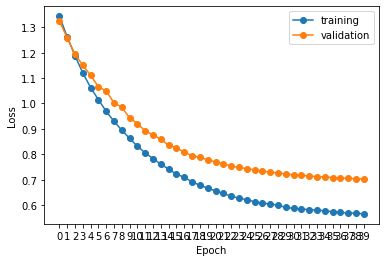

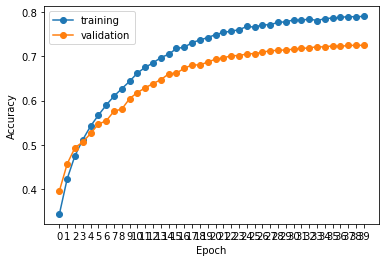

251/251 [==============================] - 11s 44ms/step - loss: 0.6781 - accuracy: 0.7432 - precision: 0.8382 - recall: 0.6100

Test Acc. 74.32%
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      1978
           1       0.74      0.78      0.76      1957
           2       0.77      0.82      0.79      2069
           3       0.73      0.67      0.70      2011

   micro avg       0.74      0.74      0.74      8015
   macro avg       0.74      0.74      0.74      8015
weighted avg       0.74      0.74      0.74      8015
 samples avg       0.74      0.74      0.74      8015

Confusion matrix
[[1396  281  129  172]
 [ 199 1522  107  129]
 [  90   82 1687  210]
 [ 209  168  282 1352]]


In [8]:

train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.01,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_filters_array=[20]
                    )

epoch: 80 ; epoch_denominator: 10.0
patience: 10 ; isConstantLearningRate: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_filters[0]; unit:20
learningRate: 0.05
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
lstm (LSTM)                  (None, 3738, 20)          1760      
_________________________________________________________________
flatten (Flatten)            (None, 74760)             0         
_______________________________________

752/752 [==============================] - 77s 102ms/step - loss: 0.0763 - accuracy: 0.9718 - precision: 0.9744 - recall: 0.9695 - val_loss: 0.4393 - val_accuracy: 0.8587 - val_precision: 0.8673 - val_recall: 0.8523
Epoch 00028: early stopping


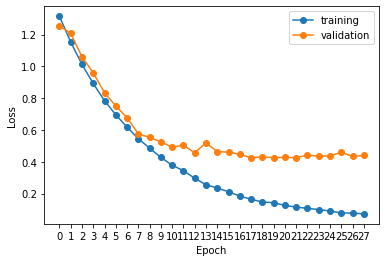

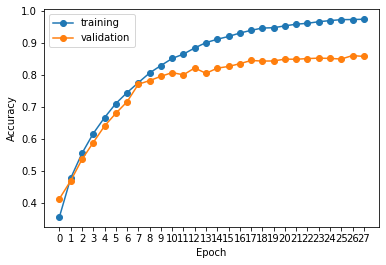

251/251 [==============================] - 11s 44ms/step - loss: 0.4374 - accuracy: 0.8640 - precision: 0.8722 - recall: 0.8578

Test Acc. 86.40%
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1978
           1       0.85      0.89      0.87      1957
           2       0.91      0.89      0.90      2069
           3       0.85      0.86      0.85      2011

   micro avg       0.86      0.86      0.86      8015
   macro avg       0.86      0.86      0.86      8015
weighted avg       0.86      0.86      0.86      8015
 samples avg       0.86      0.86      0.86      8015

Confusion matrix
[[1630  186   42  120]
 [ 120 1736   30   71]
 [  66   45 1833  125]
 [ 105   79  101 1726]]


In [9]:

train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 80, 
                     dense_layers_unit_array=[512], learningRate=0.05,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_filters_array=[20],
                     isConstantLearningRate=True
                    )

epoch: 80 ; epoch_denominator: 10.0
patience: 20 ; isConstantLearningRate: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_filters[0]; unit:20
learningRate: 0.05
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
lstm (LSTM)                  (None, 3738, 20)          1760      
_________________________________________________________________
flatten (Flatten)            (None, 74760)             0         
_______________________________________

752/752 [==============================] - 77s 103ms/step - loss: 0.0737 - accuracy: 0.9748 - precision: 0.9772 - recall: 0.9723 - val_loss: 0.4445 - val_accuracy: 0.8568 - val_precision: 0.8652 - val_recall: 0.8480
Epoch 29/80
752/752 [==============================] - 77s 102ms/step - loss: 0.0675 - accuracy: 0.9765 - precision: 0.9779 - recall: 0.9747 - val_loss: 0.4453 - val_accuracy: 0.8549 - val_precision: 0.8655 - val_recall: 0.8469
Epoch 30/80
752/752 [==============================] - 77s 103ms/step - loss: 0.0658 - accuracy: 0.9772 - precision: 0.9793 - recall: 0.9751 - val_loss: 0.4426 - val_accuracy: 0.8592 - val_precision: 0.8678 - val_recall: 0.8525
Epoch 31/80
752/752 [==============================] - 77s 103ms/step - loss: 0.0611 - accuracy: 0.9788 - precision: 0.9803 - recall: 0.9775 - val_loss: 0.4734 - val_accuracy: 0.8565 - val_precision: 0.8655 - val_recall: 0.8505
Epoch 32/80
752/752 [==============================] - 77s 102ms/step - loss: 0.0574 - accuracy: 0.9

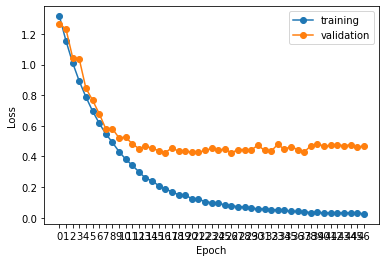

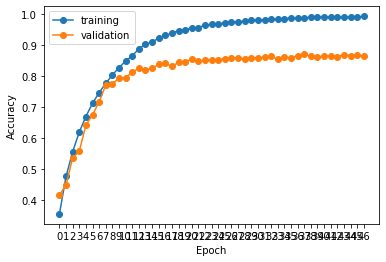

251/251 [==============================] - 11s 44ms/step - loss: 0.4621 - accuracy: 0.8715 - precision: 0.8776 - recall: 0.8674

Test Acc. 87.15%
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1978
           1       0.89      0.86      0.88      1957
           2       0.90      0.90      0.90      2069
           3       0.84      0.87      0.86      2011

   micro avg       0.87      0.87      0.87      8015
   macro avg       0.87      0.87      0.87      8015
weighted avg       0.87      0.87      0.87      8015
 samples avg       0.87      0.87      0.87      8015

Confusion matrix
[[1677  118   54  129]
 [ 150 1686   38   83]
 [  57   30 1867  115]
 [  95   51  110 1755]]


In [10]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 80, 
                     dense_layers_unit_array=[512], learningRate=0.05,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_filters_array=[20],
                     isConstantLearningRate=True,
                     patience=20
                    )

epoch: 80 ; epoch_denominator: 10.0
patience: 20 ; isConstantLearningRate: False
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPU/CPU: 2
num_of_dense_layers: 1
dense_layer[0]; unit:512
num_of_lstm_layers: 1
lstm_layer_filters[0]; unit:20
learningRate: 0.05
isBatchNormalized: False ; dropOutRate: 0.5
startWithBatchNormalized: True
optimizer: SGD ; activation: relu
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3738, 1)           4         
_________________________________________________________________
lstm (LSTM)                  (None, 3738, 20)          1760      
_________________________________________________________________
flatten (Flatten)            (None, 74760)             0         
______________________________________

752/752 [==============================] - 78s 104ms/step - loss: 0.1127 - accuracy: 0.9704 - precision: 0.9771 - recall: 0.9622 - val_loss: 0.4132 - val_accuracy: 0.8454 - val_precision: 0.8664 - val_recall: 0.8261
Epoch 30/80
752/752 [==============================] - 78s 104ms/step - loss: 0.1045 - accuracy: 0.9730 - precision: 0.9806 - recall: 0.9642 - val_loss: 0.4118 - val_accuracy: 0.8470 - val_precision: 0.8662 - val_recall: 0.8288
Epoch 31/80
752/752 [==============================] - 78s 104ms/step - loss: 0.1054 - accuracy: 0.9711 - precision: 0.9780 - recall: 0.9646 - val_loss: 0.4066 - val_accuracy: 0.8480 - val_precision: 0.8675 - val_recall: 0.8290
Epoch 32/80
752/752 [==============================] - 78s 104ms/step - loss: 0.1011 - accuracy: 0.9734 - precision: 0.9788 - recall: 0.9672 - val_loss: 0.4084 - val_accuracy: 0.8468 - val_precision: 0.8671 - val_recall: 0.8286
Epoch 33/80
752/752 [==============================] - 79s 105ms/step - loss: 0.0995 - accuracy: 0.9

Epoch 65/80
752/752 [==============================] - 78s 104ms/step - loss: 0.0769 - accuracy: 0.9826 - precision: 0.9865 - recall: 0.9767 - val_loss: 0.3995 - val_accuracy: 0.8509 - val_precision: 0.8678 - val_recall: 0.8335
Epoch 66/80
752/752 [==============================] - 79s 105ms/step - loss: 0.0775 - accuracy: 0.9833 - precision: 0.9859 - recall: 0.9789 - val_loss: 0.3996 - val_accuracy: 0.8513 - val_precision: 0.8679 - val_recall: 0.8337
Epoch 67/80
752/752 [==============================] - 79s 105ms/step - loss: 0.0759 - accuracy: 0.9823 - precision: 0.9868 - recall: 0.9787 - val_loss: 0.3996 - val_accuracy: 0.8511 - val_precision: 0.8675 - val_recall: 0.8332
Epoch 68/80
752/752 [==============================] - 79s 106ms/step - loss: 0.0788 - accuracy: 0.9814 - precision: 0.9853 - recall: 0.9768 - val_loss: 0.3996 - val_accuracy: 0.8511 - val_precision: 0.8671 - val_recall: 0.8334
Epoch 69/80
752/752 [==============================] - 79s 105ms/step - loss: 0.0757 - a

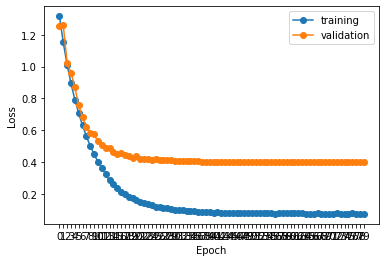

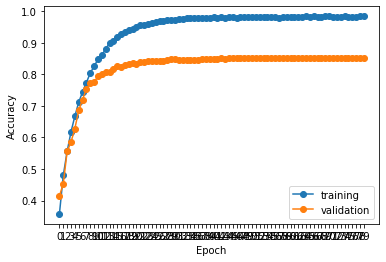

251/251 [==============================] - 11s 45ms/step - loss: 0.3872 - accuracy: 0.8554 - precision: 0.8721 - recall: 0.8412

Test Acc. 85.54%
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1978
           1       0.86      0.87      0.86      1957
           2       0.88      0.89      0.89      2069
           3       0.84      0.83      0.83      2011

   micro avg       0.86      0.86      0.86      8015
   macro avg       0.86      0.86      0.86      8015
weighted avg       0.86      0.86      0.86      8015
 samples avg       0.86      0.86      0.86      8015

Confusion matrix
[[1650  153   71  104]
 [ 132 1701   41   83]
 [  53   47 1833  136]
 [ 135   76  128 1672]]


In [12]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 80, 
                     dense_layers_unit_array=[512], learningRate=0.05,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_filters_array=[20],
                     isConstantLearningRate=False, #turn off constant learning
                     patience=20
                    )

In [ ]:
train_and_test_model(train_dataset, validate_dataset, X_train, save_to= './', epoch = 40, 
                     dense_layers_unit_array=[512], learningRate=0.05,
                     startWithBatchNormalized=True, optimizer="SGD",dropOutRate=0.5,
                     activation="relu",
                     lstm_layers_filters_array=[20,20]
                    )